# Cuffless Blood Pressure - Exploratory Data Analysis (EDA)

This notebook provides comprehensive exploratory data analysis for the cuffless blood pressure estimation project. The analysis covers:

## 📊 EDA Structure

1. **Data Loading & Overview** - Dataset statistics and basic information
2. **Signal Analysis** - PPG/ECG signal characteristics and quality assessment  
3. **Blood Pressure Distribution** - Systolic and diastolic BP patterns
4. **Demographics Analysis** - Age, gender, height, weight distributions and correlations
5. **Signal Quality Assessment** - Noise detection, signal-to-noise ratio analysis
6. **Feature Relationships** - Correlations between demographics and BP values
7. **Signal Visualization** - Time-domain and frequency-domain analysis
8. **Data Quality Checks** - Missing values, outliers, and anomaly detection
9. **Statistical Analysis** - Hypothesis testing and significance analysis
10. **Preprocessing Insights** - Signal characteristics for model preparation

## 🎯 Objective
Understand the PulseDB dataset characteristics to inform preprocessing decisions and model architecture choices for accurate blood pressure estimation from physiological signals.

In [1]:
# Run this cell once only
# %pip install --upgrade pip
%pip install -r ../requirements/requirements.txt


[notice] A new release of pip is available: 24.0 -> 26.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
processed_dir = Path('../data/processed')
npy_files = list(processed_dir.glob('*.npy'))

if npy_files:
    print(f"📊 Found {len(npy_files)} processed data files:")
    for file in npy_files:
        print(f"   - {file.name}")
    
    try:
        signals_sbp = np.load(processed_dir / 'signals_sbp.npy')
        sbp_labels = np.load(processed_dir / 'sbp_labels.npy')
        demographics_sbp = np.load(processed_dir / 'demographics_sbp.npy')
        
        print(f"\n📈 Dataset Statistics:")
        print(f"Number of samples: {len(signals_sbp)}")
        print(f"Signal length: {signals_sbp.shape[1]}")
        print(f"Demographics features: {demographics_sbp.shape[1]} (Age, Gender, Height, Weight)")
        
    except FileNotFoundError:
        print("❌ Processed .npy files not found. Please run the preprocessing notebook first.")
        signals_sbp = sbp_labels = demographics_sbp = None
else:
    print("❌ No processed data found. Please run the preprocessing notebook first.")
    signals_sbp = sbp_labels = demographics_sbp = None

📊 Found 6 processed data files:
   - signals_dbp.npy
   - dbp_labels.npy
   - demographics_sbp.npy
   - demographics_dbp.npy
   - sbp_labels.npy
   - signals_sbp.npy

📈 Dataset Statistics:
Number of samples: 201
Signal length: 1250
Demographics features: 4 (Age, Gender, Height, Weight)


In [4]:
# =============================================================================
# 1. DATASET OVERVIEW & BASIC STATISTICS
# =============================================================================

if signals_sbp is not None and sbp_labels is not None:
    print("="*70)
    print("📈 DATASET OVERVIEW")
    print("="*70)
    
    # Basic statistics
    print(f"Dataset size: {len(signals_sbp):,} samples")
    print(f"Signal length: {signals_sbp.shape[1]:,} data points")
    print(f"Signal duration: ~{signals_sbp.shape[1]/125:.1f} seconds (assuming 125 Hz)")
    print(f"Demographics features: {demographics_sbp.shape[1]} (Age, Gender, Height, Weight)")
    
    # Memory usage
    signal_size_mb = signals_sbp.nbytes / (1024**2)
    total_size_mb = (signals_sbp.nbytes + sbp_labels.nbytes + demographics_sbp.nbytes) / (1024**2)
    print(f"Memory usage: {total_size_mb:.1f} MB (signals: {signal_size_mb:.1f} MB)")
    
    print("\n" + "="*50)
    print("🔢 BLOOD PRESSURE STATISTICS")
    print("="*50)
    
    # SBP statistics
    print("Systolic Blood Pressure (SBP):")
    print(f"  Mean: {np.mean(sbp_labels):.1f} ± {np.std(sbp_labels):.1f} mmHg")
    print(f"  Range: {np.min(sbp_labels):.1f} - {np.max(sbp_labels):.1f} mmHg")
    print(f"  Median: {np.median(sbp_labels):.1f} mmHg")
    print(f"  25th percentile: {np.percentile(sbp_labels, 25):.1f} mmHg")
    print(f"  75th percentile: {np.percentile(sbp_labels, 75):.1f} mmHg")
    
    # BP categories (American Heart Association guidelines)
    normal = np.sum(sbp_labels < 120)
    elevated = np.sum((sbp_labels >= 120) & (sbp_labels < 130))
    stage1 = np.sum((sbp_labels >= 130) & (sbp_labels < 140))
    stage2 = np.sum(sbp_labels >= 140)
    
    print("\n📊 BP Categories (AHA Guidelines):")
    print(f"  Normal (<120): {normal:,} ({100*normal/len(sbp_labels):.1f}%)")
    print(f"  Elevated (120-129): {elevated:,} ({100*elevated/len(sbp_labels):.1f}%)")
    print(f"  Stage 1 (130-139): {stage1:,} ({100*stage1/len(sbp_labels):.1f}%)")
    print(f"  Stage 2 (≥140): {stage2:,} ({100*stage2/len(sbp_labels):.1f}%)")
    
    print("\n" + "="*50)
    print("👥 DEMOGRAPHICS OVERVIEW")
    print("="*50)
    
    # Demographics statistics
    age, gender, height, weight = demographics_sbp.T
    
    print("Age:")
    print(f"  Mean: {np.mean(age):.1f} ± {np.std(age):.1f} years")
    print(f"  Range: {np.min(age):.0f} - {np.max(age):.0f} years")
    
    print("\nGender Distribution:")
    male_count = np.sum(gender == 1)
    female_count = np.sum(gender == 0)
    print(f"  Male: {male_count:,} ({100*male_count/len(gender):.1f}%)")
    print(f"  Female: {female_count:,} ({100*female_count/len(gender):.1f}%)")
    
    print(f"\nHeight: {np.mean(height):.1f} ± {np.std(height):.1f} cm")
    print(f"Weight: {np.mean(weight):.1f} ± {np.std(weight):.1f} kg")
    
    # BMI calculation
    height_m = height / 100  # convert cm to meters
    bmi = weight / (height_m ** 2)
    print(f"BMI: {np.mean(bmi):.1f} ± {np.std(bmi):.1f}")
    
else:
    print("⚠️  No data loaded. Please run preprocessing first.")
    print("This section will show comprehensive dataset statistics when data is available.")

📈 DATASET OVERVIEW
Dataset size: 201 samples
Signal length: 1,250 data points
Signal duration: ~10.0 seconds (assuming 125 Hz)
Demographics features: 4 (Age, Gender, Height, Weight)
Memory usage: 1.9 MB (signals: 1.9 MB)

🔢 BLOOD PRESSURE STATISTICS
Systolic Blood Pressure (SBP):
  Mean: 146.1 ± 13.7 mmHg
  Range: 91.5 - 175.3 mmHg
  Median: 150.5 mmHg
  25th percentile: 136.9 mmHg
  75th percentile: 156.6 mmHg

📊 BP Categories (AHA Guidelines):
  Normal (<120): 7 (3.5%)
  Elevated (120-129): 6 (3.0%)
  Stage 1 (130-139): 56 (27.9%)
  Stage 2 (≥140): 132 (65.7%)

👥 DEMOGRAPHICS OVERVIEW
Age:
  Mean: 64.0 ± 0.0 years
  Range: 64 - 64 years

Gender Distribution:
  Male: 201 (100.0%)
  Female: 0 (0.0%)

Height: 175.1 ± 0.0 cm
Weight: 77.4 ± 0.0 kg
BMI: 25.2 ± 0.0


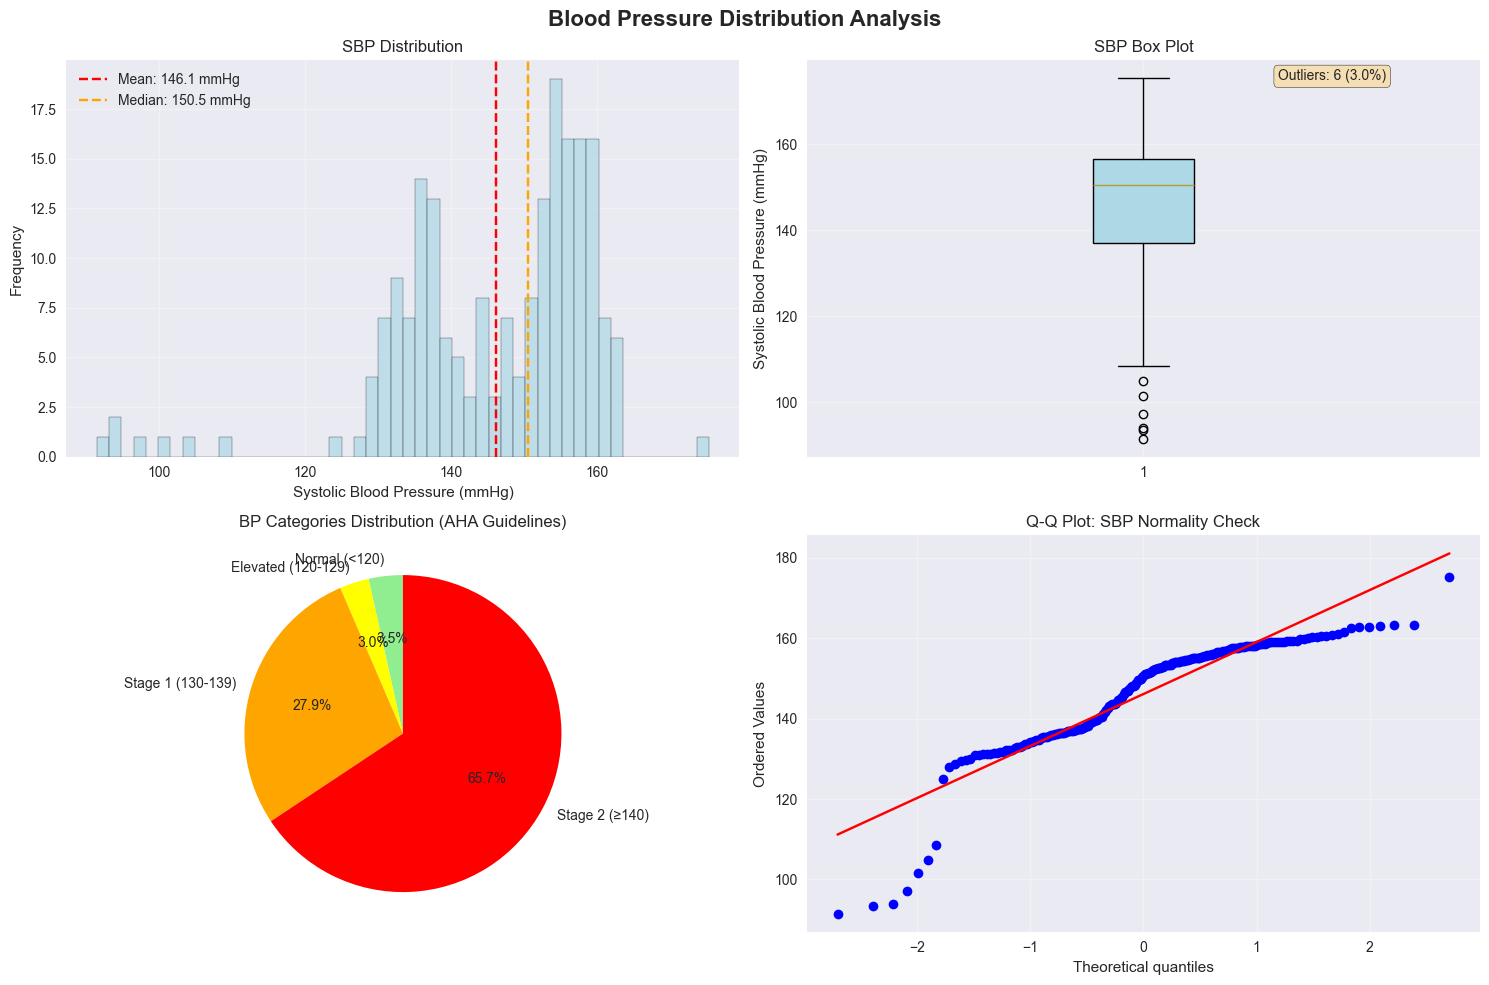


📊 STATISTICAL TESTS
Shapiro-Wilk normality test (p-value): 4.81e-12
Distribution is not normal (α=0.05)
Skewness: -1.406 (left-skewed)
Kurtosis: 3.014 (leptokurtic)


In [5]:
# =============================================================================
# 2. BLOOD PRESSURE DISTRIBUTION ANALYSIS
# =============================================================================

if signals_sbp is not None and sbp_labels is not None:
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Blood Pressure Distribution Analysis', fontsize=16, fontweight='bold')
    
    # Histogram of SBP values
    axes[0, 0].hist(sbp_labels, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
    axes[0, 0].axvline(np.mean(sbp_labels), color='red', linestyle='--', 
                       label=f'Mean: {np.mean(sbp_labels):.1f} mmHg')
    axes[0, 0].axvline(np.median(sbp_labels), color='orange', linestyle='--', 
                       label=f'Median: {np.median(sbp_labels):.1f} mmHg')
    axes[0, 0].set_xlabel('Systolic Blood Pressure (mmHg)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('SBP Distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Box plot of SBP
    bp = axes[0, 1].boxplot(sbp_labels, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    axes[0, 1].set_ylabel('Systolic Blood Pressure (mmHg)')
    axes[0, 1].set_title('SBP Box Plot')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Add outlier statistics
    Q1 = np.percentile(sbp_labels, 25)
    Q3 = np.percentile(sbp_labels, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = np.sum((sbp_labels < lower_bound) | (sbp_labels > upper_bound))
    axes[0, 1].text(0.7, 0.95, f'Outliers: {outliers} ({100*outliers/len(sbp_labels):.1f}%)', 
                    transform=axes[0, 1].transAxes, bbox=dict(boxstyle="round", facecolor='wheat'))
    
    # BP categories pie chart
    bp_categories = ['Normal (<120)', 'Elevated (120-129)', 'Stage 1 (130-139)', 'Stage 2 (≥140)']
    bp_counts = [
        np.sum(sbp_labels < 120),
        np.sum((sbp_labels >= 120) & (sbp_labels < 130)),
        np.sum((sbp_labels >= 130) & (sbp_labels < 140)),
        np.sum(sbp_labels >= 140)
    ]
    colors = ['lightgreen', 'yellow', 'orange', 'red']
    
    wedges, texts, autotexts = axes[1, 0].pie(bp_counts, labels=bp_categories, autopct='%1.1f%%', 
                                              colors=colors, startangle=90)
    axes[1, 0].set_title('BP Categories Distribution (AHA Guidelines)')
    
    # Q-Q plot for normality check
    from scipy import stats
    stats.probplot(sbp_labels, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot: SBP Normality Check')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical tests
    print("\n" + "="*50)
    print("📊 STATISTICAL TESTS")
    print("="*50)
    
    # Normality test
    shapiro_stat, shapiro_p = stats.shapiro(sbp_labels[:5000] if len(sbp_labels) > 5000 else sbp_labels)
    print(f"Shapiro-Wilk normality test (p-value): {shapiro_p:.2e}")
    print(f"Distribution is {'normal' if shapiro_p > 0.05 else 'not normal'} (α=0.05)")
    
    # Skewness and kurtosis
    skewness = stats.skew(sbp_labels)
    kurt = stats.kurtosis(sbp_labels)
    print(f"Skewness: {skewness:.3f} ({'right-skewed' if skewness > 0 else 'left-skewed' if skewness < 0 else 'symmetric'})")
    print(f"Kurtosis: {kurt:.3f} ({'leptokurtic' if kurt > 0 else 'platykurtic' if kurt < 0 else 'mesokurtic'})")
    
else:
    print("⚠️  No data loaded.")
    print("This section will create blood pressure distribution visualizations when data is available.")


🔍 DATA QUALITY ANALYSIS


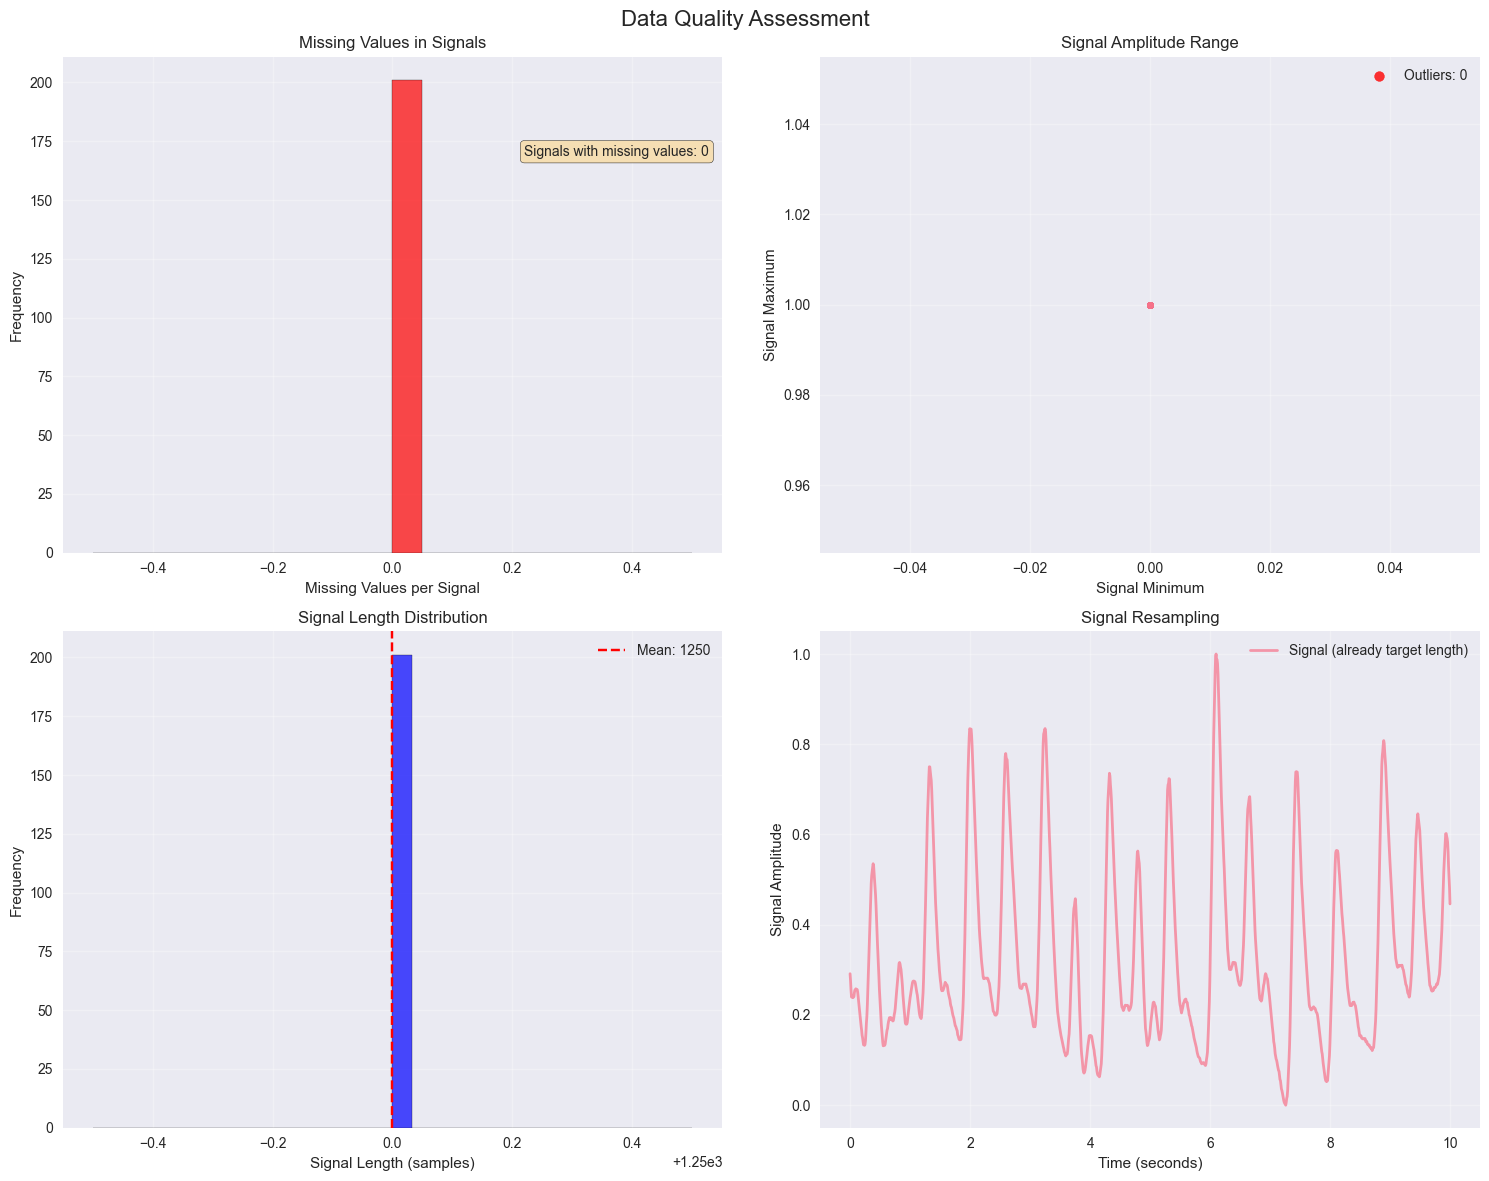


📊 Quality Summary:
Total signals: 201
Signals with missing values: 0
Mean signal length: 1250 samples
Signal length std: 0 samples
Amplitude outliers: 0


In [6]:
def analyze_data_quality():
    """Analyze data quality including missing values, outliers, and signal integrity."""
    print("\n" + "="*60)
    print("🔍 DATA QUALITY ANALYSIS")
    print("="*60)
    
    # 1. Check for missing values in signals
    missing_signals = np.sum(np.isnan(signals_sbp), axis=1)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Data Quality Assessment', fontsize=16, y=0.98)
    
    # 1. Missing values distribution
    axes[0, 0].hist(missing_signals, bins=20, alpha=0.7, color='red', edgecolor='black')
    axes[0, 0].set_xlabel('Missing Values per Signal')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Missing Values in Signals')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add text annotation
    total_missing = np.sum(missing_signals > 0)
    axes[0, 0].text(0.7, 0.8, f'Signals with missing values: {total_missing}', 
                    transform=axes[0, 0].transAxes, 
                    bbox=dict(boxstyle="round", facecolor='wheat'))
    
    # 2. Signal amplitude outliers
    signal_max = np.max(signals_sbp, axis=1)
    signal_min = np.min(signals_sbp, axis=1)
    
    axes[0, 1].scatter(signal_min, signal_max, alpha=0.6, s=20)
    axes[0, 1].set_xlabel('Signal Minimum')
    axes[0, 1].set_ylabel('Signal Maximum')
    axes[0, 1].set_title('Signal Amplitude Range')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Identify extreme outliers (beyond 3 standard deviations)
    range_vals = signal_max - signal_min
    outlier_threshold = np.mean(range_vals) + 3*np.std(range_vals)
    outliers = range_vals > outlier_threshold
    axes[0, 1].scatter(signal_min[outliers], signal_max[outliers], 
                      color='red', s=50, alpha=0.8, label=f'Outliers: {np.sum(outliers)}')
    axes[0, 1].legend()
    
    # 3. Signal length distribution
    signal_lengths = [len(sig) for sig in signals_sbp if not np.all(np.isnan(sig))]
    
    axes[1, 0].hist(signal_lengths, bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[1, 0].set_xlabel('Signal Length (samples)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Signal Length Distribution')
    axes[1, 0].axvline(np.mean(signal_lengths), color='red', linestyle='--', 
                      label=f'Mean: {np.mean(signal_lengths):.0f}')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Resampling demonstration (if signals have different lengths)
    demo_signal = signals_sbp[0][~np.isnan(signals_sbp[0])]
    time_axis = np.arange(len(demo_signal)) / 125  # Assuming 125 Hz sampling
    
    target_length = int(np.median(signal_lengths))
    if len(demo_signal) != target_length:
        from scipy.signal import resample
        resampled_signal = resample(demo_signal, target_length)
        time_resampled = np.arange(target_length) / 125
        
        axes[1, 1].plot(time_axis, demo_signal, alpha=0.7, 
                       label=f'Original ({len(demo_signal)} samples)', linewidth=2)
        axes[1, 1].plot(time_resampled, resampled_signal, alpha=0.8, 
                       label=f'Resampled ({target_length} samples)', linewidth=2)
    else:
        axes[1, 1].plot(time_axis, demo_signal, alpha=0.7, 
                       label='Signal (already target length)', linewidth=2)
    
    axes[1, 1].set_xlabel('Time (seconds)')
    axes[1, 1].set_ylabel('Signal Amplitude')
    axes[1, 1].set_title('Signal Resampling')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n📊 Quality Summary:")
    print(f"Total signals: {len(signals_sbp)}")
    print(f"Signals with missing values: {total_missing}")
    print(f"Mean signal length: {np.mean(signal_lengths):.0f} samples")
    print(f"Signal length std: {np.std(signal_lengths):.0f} samples")
    print(f"Amplitude outliers: {np.sum(outliers)}")
    
analyze_data_quality()

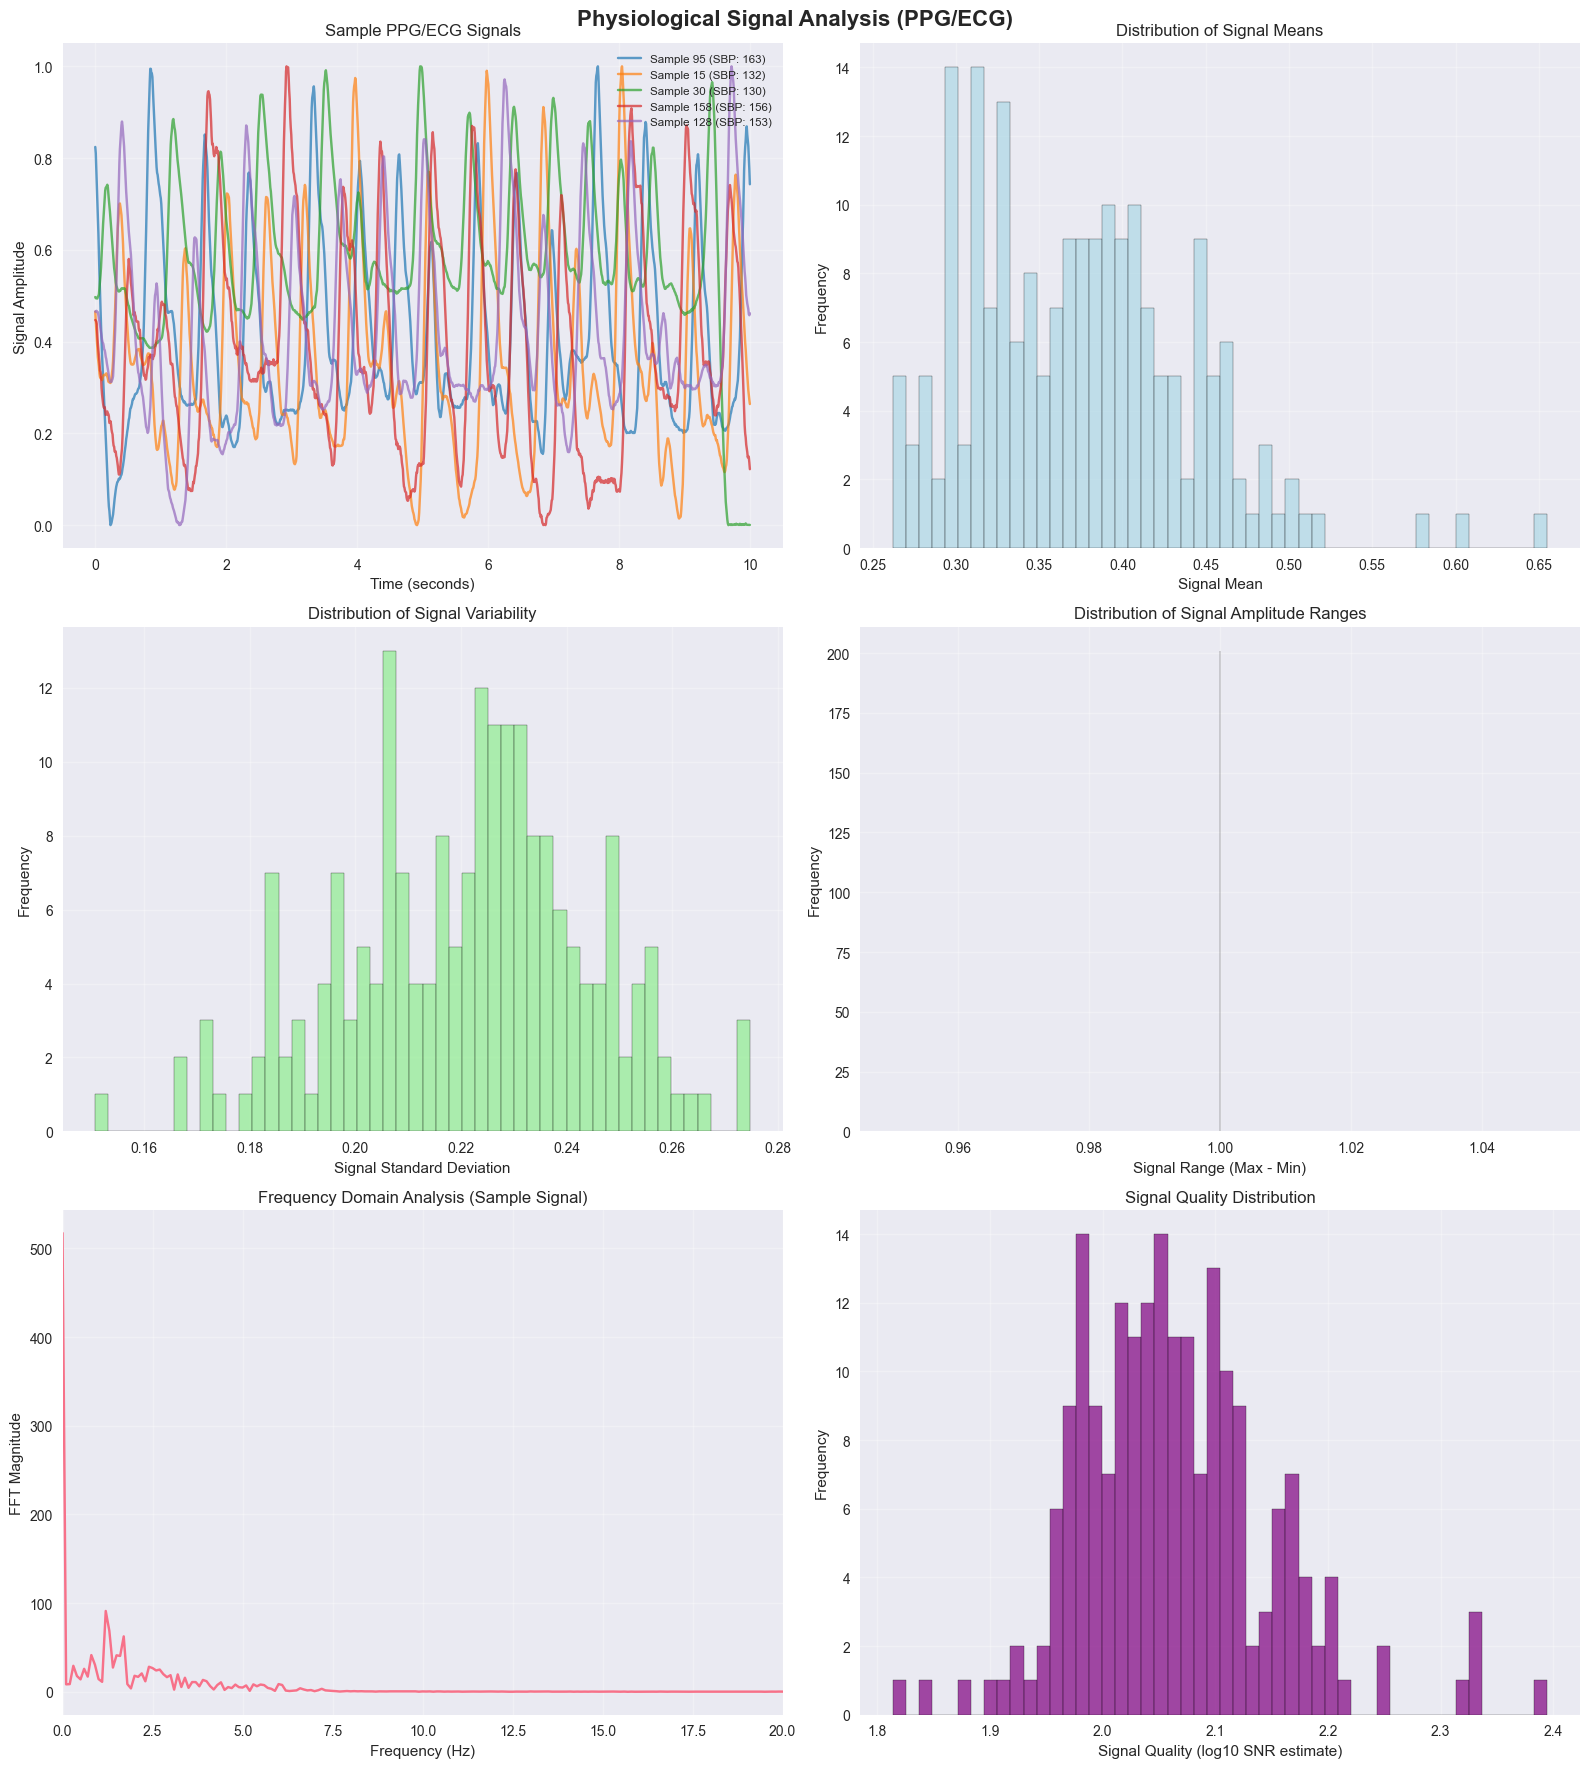


📊 SIGNAL CHARACTERISTICS ANALYSIS
Signal length: 1250 samples
Estimated duration: 10.0 seconds (@ 125 Hz)
Signal amplitude range: 0.000 to 1.000
Mean signal amplitude: 0.375 ± 0.066
Mean signal variability: 0.221 ± 0.023
Average amplitude range: 1.000 ± 0.000

Signal-BP Correlations:
  Signal mean vs SBP: r = 0.186
  Signal std vs SBP: r = 0.292
  Signal range vs SBP: r = 0.057


In [7]:
# =============================================================================
# 4. SIGNAL ANALYSIS & VISUALIZATION
# =============================================================================

if signals_sbp is not None:
    from scipy.fft import fft, fftfreq
    
    # Select random samples for visualization
    np.random.seed(42)  # For reproducibility
    sample_indices = np.random.choice(len(signals_sbp), size=min(10, len(signals_sbp)), replace=False)
    
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle('Physiological Signal Analysis (PPG/ECG)', fontsize=16, fontweight='bold')
    
    # 1. Signal examples (time domain)
    time_axis = np.arange(signals_sbp.shape[1]) / 125  # Assuming 125 Hz sampling rate
    
    for i, idx in enumerate(sample_indices[:5]):
        color = plt.cm.tab10(i)
        axes[0, 0].plot(time_axis, signals_sbp[idx], alpha=0.7, 
                       label=f'Sample {idx} (SBP: {sbp_labels[idx]:.0f})', color=color)
    
    axes[0, 0].set_xlabel('Time (seconds)')
    axes[0, 0].set_ylabel('Signal Amplitude')
    axes[0, 0].set_title('Sample PPG/ECG Signals')
    axes[0, 0].legend(loc='upper right', fontsize='small')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Signal statistics distribution
    signal_means = np.mean(signals_sbp, axis=1)
    signal_stds = np.std(signals_sbp, axis=1)
    
    axes[0, 1].hist(signal_means, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
    axes[0, 1].set_xlabel('Signal Mean')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Distribution of Signal Means')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Signal variance analysis
    axes[1, 0].hist(signal_stds, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1, 0].set_xlabel('Signal Standard Deviation')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Signal Variability')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Signal amplitude range
    signal_ranges = np.max(signals_sbp, axis=1) - np.min(signals_sbp, axis=1)
    axes[1, 1].hist(signal_ranges, bins=1, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 1].set_xlabel('Signal Range (Max - Min)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Distribution of Signal Amplitude Ranges')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 5. Frequency domain analysis (FFT of sample signals)
    sample_signal = signals_sbp[sample_indices[0]]
    fft_vals = np.abs(fft(sample_signal))
    freqs = fftfreq(len(sample_signal), 1/125)  # 125 Hz sampling rate
    
    # Plot only positive frequencies up to Nyquist
    pos_mask = freqs >= 0
    axes[2, 0].plot(freqs[pos_mask][:len(freqs)//2], 
                   fft_vals[pos_mask][:len(freqs)//2])
    axes[2, 0].set_xlabel('Frequency (Hz)')
    axes[2, 0].set_ylabel('FFT Magnitude')
    axes[2, 0].set_title('Frequency Domain Analysis (Sample Signal)')
    axes[2, 0].set_xlim(0, 20)  # Focus on physiologically relevant frequencies
    axes[2, 0].grid(True, alpha=0.3)
    
    # 6. Signal quality metrics
    # Calculate SNR-like metric (signal power vs noise estimation)
    signal_power = np.var(signals_sbp, axis=1)
    noise_est = np.std(np.diff(signals_sbp, axis=1), axis=1)  # High-frequency noise estimate
    snr_estimate = signal_power / (noise_est**2 + 1e-10)  # Avoid division by zero
    
    axes[2, 1].hist(np.log10(snr_estimate), bins=50, alpha=0.7, color='purple', edgecolor='black')
    axes[2, 1].set_xlabel('Signal Quality (log10 SNR estimate)')
    axes[2, 1].set_ylabel('Frequency')
    axes[2, 1].set_title('Signal Quality Distribution')
    axes[2, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Signal statistics summary
    print("\n" + "="*60)
    print("📊 SIGNAL CHARACTERISTICS ANALYSIS")
    print("="*60)
    
    print(f"Signal length: {signals_sbp.shape[1]} samples")
    print(f"Estimated duration: {signals_sbp.shape[1]/125:.1f} seconds (@ 125 Hz)")
    print(f"Signal amplitude range: {np.min(signals_sbp):.3f} to {np.max(signals_sbp):.3f}")
    print(f"Mean signal amplitude: {np.mean(signal_means):.3f} ± {np.std(signal_means):.3f}")
    print(f"Mean signal variability: {np.mean(signal_stds):.3f} ± {np.std(signal_stds):.3f}")
    print(f"Average amplitude range: {np.mean(signal_ranges):.3f} ± {np.std(signal_ranges):.3f}")
    
    # Correlation between signal characteristics and BP
    corr_mean_bp = np.corrcoef(signal_means, sbp_labels)[0, 1]
    corr_std_bp = np.corrcoef(signal_stds, sbp_labels)[0, 1]
    corr_range_bp = np.corrcoef(signal_ranges, sbp_labels)[0, 1]
    
    print(f"\nSignal-BP Correlations:")
    print(f"  Signal mean vs SBP: r = {corr_mean_bp:.3f}")
    print(f"  Signal std vs SBP: r = {corr_std_bp:.3f}")
    print(f"  Signal range vs SBP: r = {corr_range_bp:.3f}")
    
else:
    print("⚠️  No signal data loaded.")
    print("This section will analyze PPG/ECG signal characteristics when data is available.")


🔍 COMPREHENSIVE DATA QUALITY ASSESSMENT


/var/folders/_g/gf4yrzvs5yjgdxqql4xt3pww0000gn/T/ipykernel_15659/1297064814.py:40: RuntimeWarning: invalid value encountered in divide
  z_min = np.abs((signal_min - np.mean(signal_min)) / np.std(signal_min))


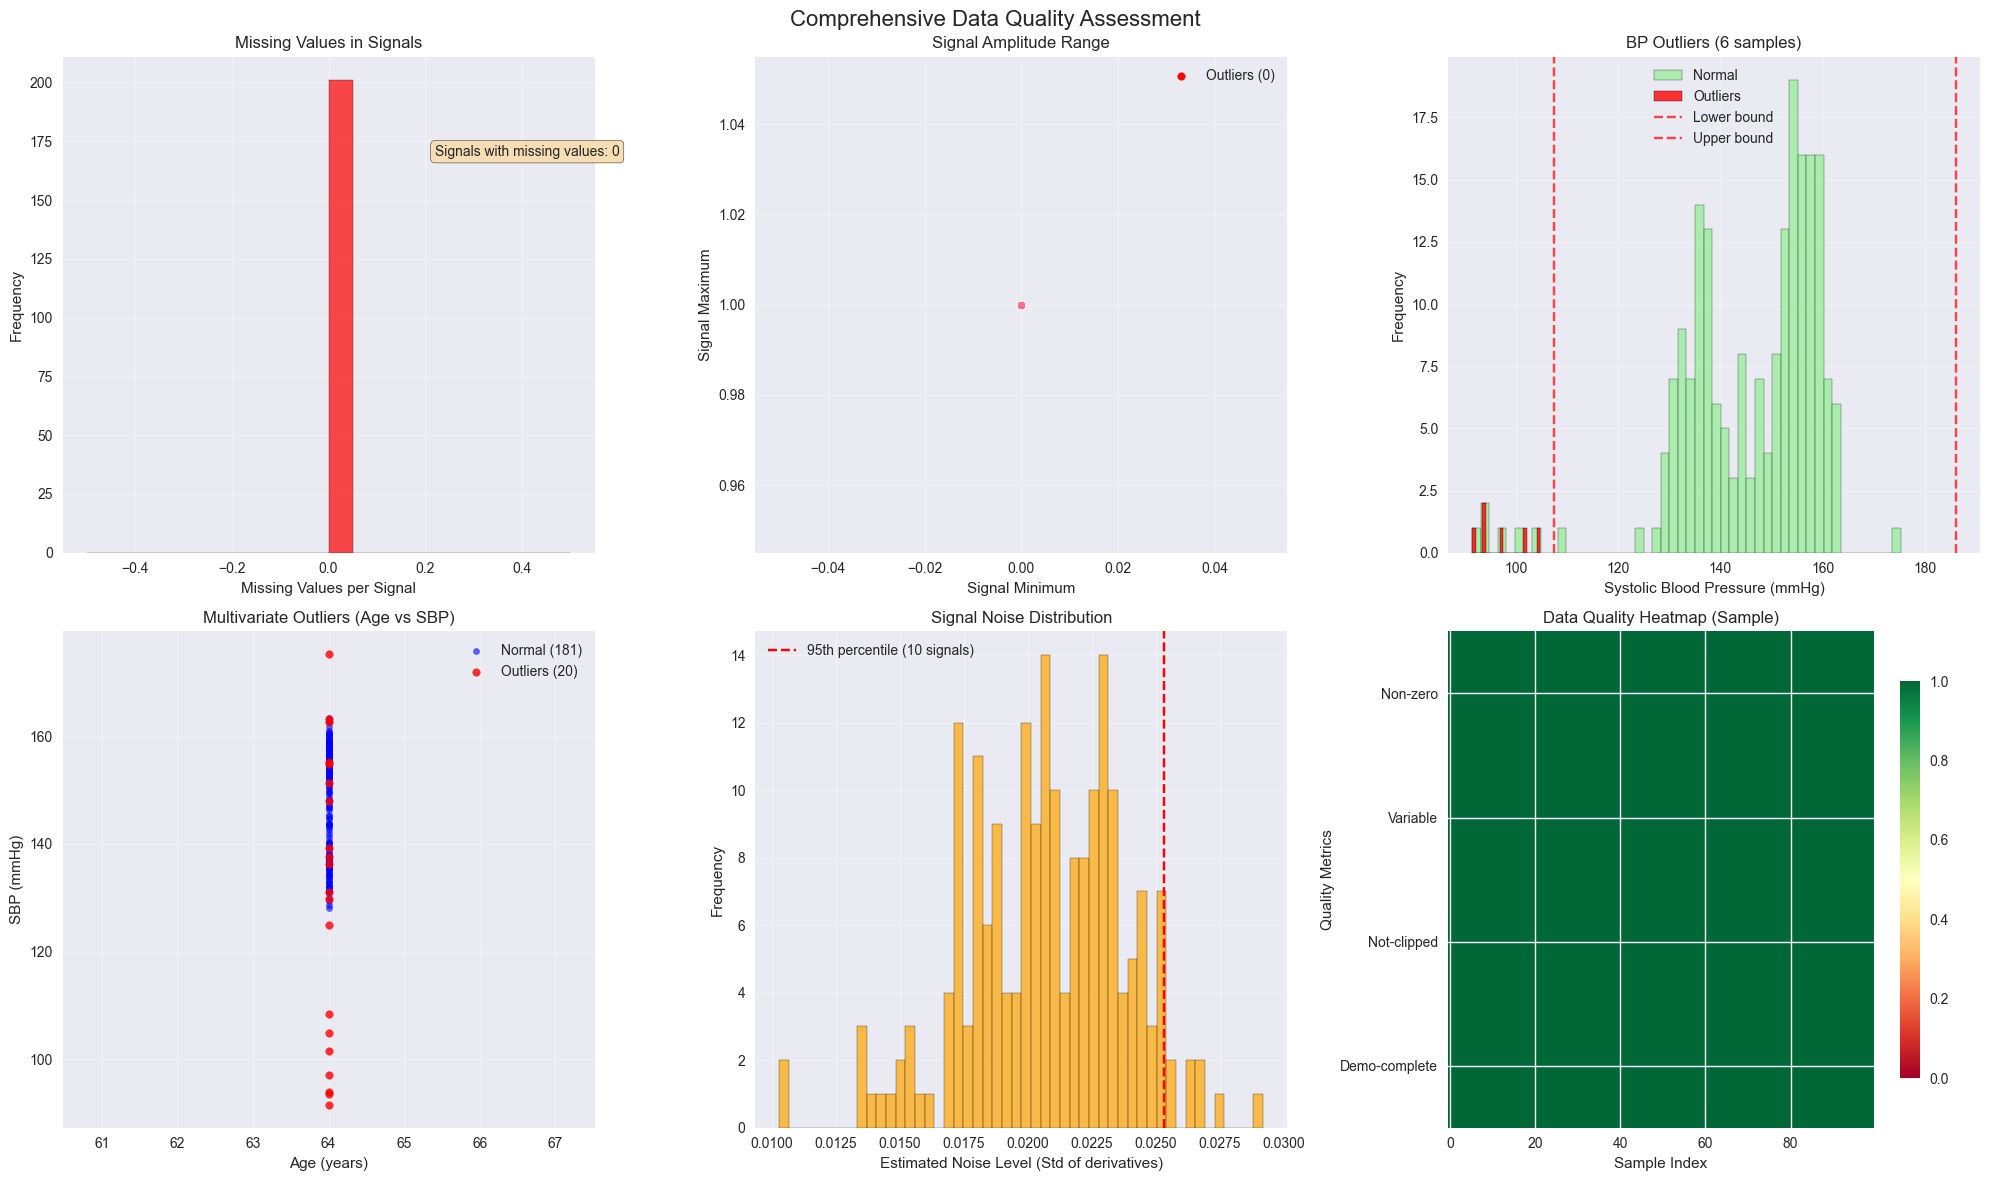


🔍 DATA QUALITY ASSESSMENT SUMMARY
Total samples: 201
Signals with missing values: 0
Demographics with missing values: 0

Outlier Detection:
  Signal amplitude outliers: 0 (0.0%)
  Blood pressure outliers (IQR): 6 (3.0%)
  Multivariate outliers (Isolation Forest): 20 (10.0%)
  Noisy signals (top 5%): 10 (5.0%)

Signal Quality Metrics:
  Mean noise level: 0.0207 ± 0.0031
  Average signal completeness: 0.999

💡 Data Quality Recommendations:


In [8]:
def analyze_comprehensive_data_quality():
    """Comprehensive data quality analysis including outlier detection and multivariate analysis."""
    if 'signals_sbp' in globals() and signals_sbp is not None:
        print("\n" + "="*60)
        print("🔍 COMPREHENSIVE DATA QUALITY ASSESSMENT")
        print("="*60)
        
        # Prepare data
        missing_signals = np.sum(np.isnan(signals_sbp), axis=1)
        missing_demographics = np.sum(np.isnan(demographics_sbp), axis=1)
        
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle('Comprehensive Data Quality Assessment', fontsize=16, y=0.98)
        
        # 1. Missing values distribution
        axes[0, 0].hist(missing_signals, bins=20, alpha=0.7, color='red', edgecolor='black')
        axes[0, 0].set_xlabel('Missing Values per Signal')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Missing Values in Signals')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Add text annotation
        total_missing = np.sum(missing_signals > 0)
        axes[0, 0].text(0.7, 0.8, f'Signals with missing values: {total_missing}', 
                        transform=axes[0, 0].transAxes, 
                        bbox=dict(boxstyle="round", facecolor='wheat'))
        
        # 2. Signal amplitude outliers
        signal_max = np.max(signals_sbp, axis=1)
        signal_min = np.min(signals_sbp, axis=1)
        
        axes[0, 1].scatter(signal_min, signal_max, alpha=0.6, s=20)
        axes[0, 1].set_xlabel('Signal Minimum')
        axes[0, 1].set_ylabel('Signal Maximum')
        axes[0, 1].set_title('Signal Amplitude Range')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Identify extreme outliers (beyond 3 standard deviations)
        z_max = np.abs((signal_max - np.mean(signal_max)) / np.std(signal_max))
        z_min = np.abs((signal_min - np.mean(signal_min)) / np.std(signal_min))
        amplitude_outliers = (z_max > 3) | (z_min > 3)
        
        axes[0, 1].scatter(signal_min[amplitude_outliers], signal_max[amplitude_outliers], 
                          color='red', s=30, label=f'Outliers ({np.sum(amplitude_outliers)})')
        axes[0, 1].legend()
        
        # 3. Blood pressure outliers
        # Using IQR method for BP outliers
        Q1_bp = np.percentile(sbp_labels, 25)
        Q3_bp = np.percentile(sbp_labels, 75)
        IQR_bp = Q3_bp - Q1_bp
        bp_outliers = (sbp_labels < (Q1_bp - 1.5 * IQR_bp)) | (sbp_labels > (Q3_bp + 1.5 * IQR_bp))
        
        axes[0, 2].hist(sbp_labels, bins=50, alpha=0.7, color='lightgreen', edgecolor='black', label='Normal')
        axes[0, 2].hist(sbp_labels[bp_outliers], bins=20, alpha=0.8, color='red', edgecolor='black', label='Outliers')
        axes[0, 2].axvline(Q1_bp - 1.5 * IQR_bp, color='red', linestyle='--', alpha=0.7, label='Lower bound')
        axes[0, 2].axvline(Q3_bp + 1.5 * IQR_bp, color='red', linestyle='--', alpha=0.7, label='Upper bound')
        axes[0, 2].set_xlabel('Systolic Blood Pressure (mmHg)')
        axes[0, 2].set_ylabel('Frequency')
        axes[0, 2].set_title(f'BP Outliers ({np.sum(bp_outliers)} samples)')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
        
        # 4. Multivariate outlier detection using Isolation Forest
        from sklearn.ensemble import IsolationForest
        from sklearn.preprocessing import StandardScaler
        
        # Combine signal features and demographics
        features = np.column_stack([
            np.mean(signals_sbp, axis=1),
            np.std(signals_sbp, axis=1),
            np.max(signals_sbp, axis=1) - np.min(signals_sbp, axis=1),
            demographics_sbp[:, 0],  # Age
            demographics_sbp[:, 2],  # Height
            demographics_sbp[:, 3],  # Weight
            sbp_labels
        ])
        
        # Standardize features
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)
        
        # Apply Isolation Forest
        iso_forest = IsolationForest(contamination=0.1, random_state=42)  # Expect 10% outliers
        outlier_labels = iso_forest.fit_predict(features_scaled)
        outliers = outlier_labels == -1
        
        # Plot age vs SBP with outliers highlighted
        age = demographics_sbp[:, 0]
        axes[1, 0].scatter(age[~outliers], sbp_labels[~outliers], alpha=0.6, s=20, 
                          color='blue', label=f'Normal ({np.sum(~outliers)})')
        axes[1, 0].scatter(age[outliers], sbp_labels[outliers], alpha=0.8, s=30, 
                          color='red', label=f'Outliers ({np.sum(outliers)})')
        axes[1, 0].set_xlabel('Age (years)')
        axes[1, 0].set_ylabel('SBP (mmHg)')
        axes[1, 0].set_title('Multivariate Outliers (Age vs SBP)')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # 5. Signal noise analysis
        # High-frequency noise estimation using signal derivatives
        signal_noise = np.std(np.diff(signals_sbp, axis=1), axis=1)
        
        axes[1, 1].hist(signal_noise, bins=50, alpha=0.7, color='orange', edgecolor='black')
        axes[1, 1].set_xlabel('Estimated Noise Level (Std of derivatives)')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('Signal Noise Distribution')
        axes[1, 1].grid(True, alpha=0.3)
        
        # Identify noisy signals
        noise_threshold = np.percentile(signal_noise, 95)  # Top 5% as noisy
        noisy_signals = signal_noise > noise_threshold
        axes[1, 1].axvline(noise_threshold, color='red', linestyle='--', 
                          label=f'95th percentile ({np.sum(noisy_signals)} signals)')
        axes[1, 1].legend()
        
        # 6. Data completeness heatmap
        # Create a sample of data completeness (for visualization)
        sample_size = min(100, len(signals_sbp))
        sample_indices = np.random.choice(len(signals_sbp), sample_size, replace=False)
        
        # Check for zeros or constant segments in signals (potential data quality issues)
        completeness_matrix = np.zeros((sample_size, 4))  # 4 quality metrics
        
        for i, idx in enumerate(sample_indices):
            signal = signals_sbp[idx]
            # Metric 1: Non-zero ratio
            completeness_matrix[i, 0] = np.mean(signal != 0)
            # Metric 2: Non-constant ratio (signal variability)
            completeness_matrix[i, 1] = 1 - (np.sum(signal == signal[0]) / len(signal))
            # Metric 3: Reasonable amplitude (not clipped)
            completeness_matrix[i, 2] = 1 - ((np.sum(signal == np.max(signal)) + 
                                             np.sum(signal == np.min(signal))) / len(signal))
            # Metric 4: Demographics completeness
            completeness_matrix[i, 3] = 1 - (np.sum(np.isnan(demographics_sbp[idx])) / len(demographics_sbp[idx]))
        
        im = axes[1, 2].imshow(completeness_matrix.T, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
        axes[1, 2].set_xlabel('Sample Index')
        axes[1, 2].set_ylabel('Quality Metrics')
        axes[1, 2].set_title('Data Quality Heatmap (Sample)')
        axes[1, 2].set_yticks([0, 1, 2, 3])
        axes[1, 2].set_yticklabels(['Non-zero', 'Variable', 'Not-clipped', 'Demo-complete'])
        
        # Add colorbar
        plt.colorbar(im, ax=axes[1, 2], shrink=0.8)
        
        plt.tight_layout()
        plt.show()
        
        # Data quality summary
        print("\n" + "="*60)
        print("🔍 DATA QUALITY ASSESSMENT SUMMARY")
        print("="*60)
        
        print(f"Total samples: {len(signals_sbp):,}")
        print(f"Signals with missing values: {np.sum(missing_signals > 0)}")
        print(f"Demographics with missing values: {np.sum(missing_demographics > 0)}")
        
        print(f"\nOutlier Detection:")
        print(f"  Signal amplitude outliers: {np.sum(amplitude_outliers)} ({100*np.sum(amplitude_outliers)/len(signals_sbp):.1f}%)")
        print(f"  Blood pressure outliers (IQR): {np.sum(bp_outliers)} ({100*np.sum(bp_outliers)/len(sbp_labels):.1f}%)")
        print(f"  Multivariate outliers (Isolation Forest): {np.sum(outliers)} ({100*np.sum(outliers)/len(signals_sbp):.1f}%)")
        print(f"  Noisy signals (top 5%): {np.sum(noisy_signals)} ({100*np.sum(noisy_signals)/len(signals_sbp):.1f}%)")
        
        print(f"\nSignal Quality Metrics:")
        print(f"  Mean noise level: {np.mean(signal_noise):.4f} ± {np.std(signal_noise):.4f}")
        print(f"  Average signal completeness: {np.mean(completeness_matrix):.3f}")
        
        # Recommendations
        print(f"\n💡 Data Quality Recommendations:")
        if np.sum(amplitude_outliers) > len(signals_sbp) * 0.05:
            print(f"  ⚠️  High number of amplitude outliers - consider signal normalization")
        if np.sum(noisy_signals) > len(signals_sbp) * 0.1:
            print(f"  ⚠️  Many noisy signals detected - apply filtering in preprocessing")
        if np.sum(bp_outliers) > len(sbp_labels) * 0.05:
            print(f"  ⚠️  Significant BP outliers - verify measurement accuracy")
        if np.mean(completeness_matrix) < 0.95:
            print(f"  ⚠️  Data completeness issues detected - investigate data collection")
            
    else:
        print("⚠️  No data loaded.")
        print("This section will assess data quality and detect outliers when data is available.")

analyze_comprehensive_data_quality()

\n============================================================
🔬 FEATURE ENGINEERING ANALYSIS


/Users/nischal0x01/code/ku/pulseAI/venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nischal0x01/code/ku/pulseAI/venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3024: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


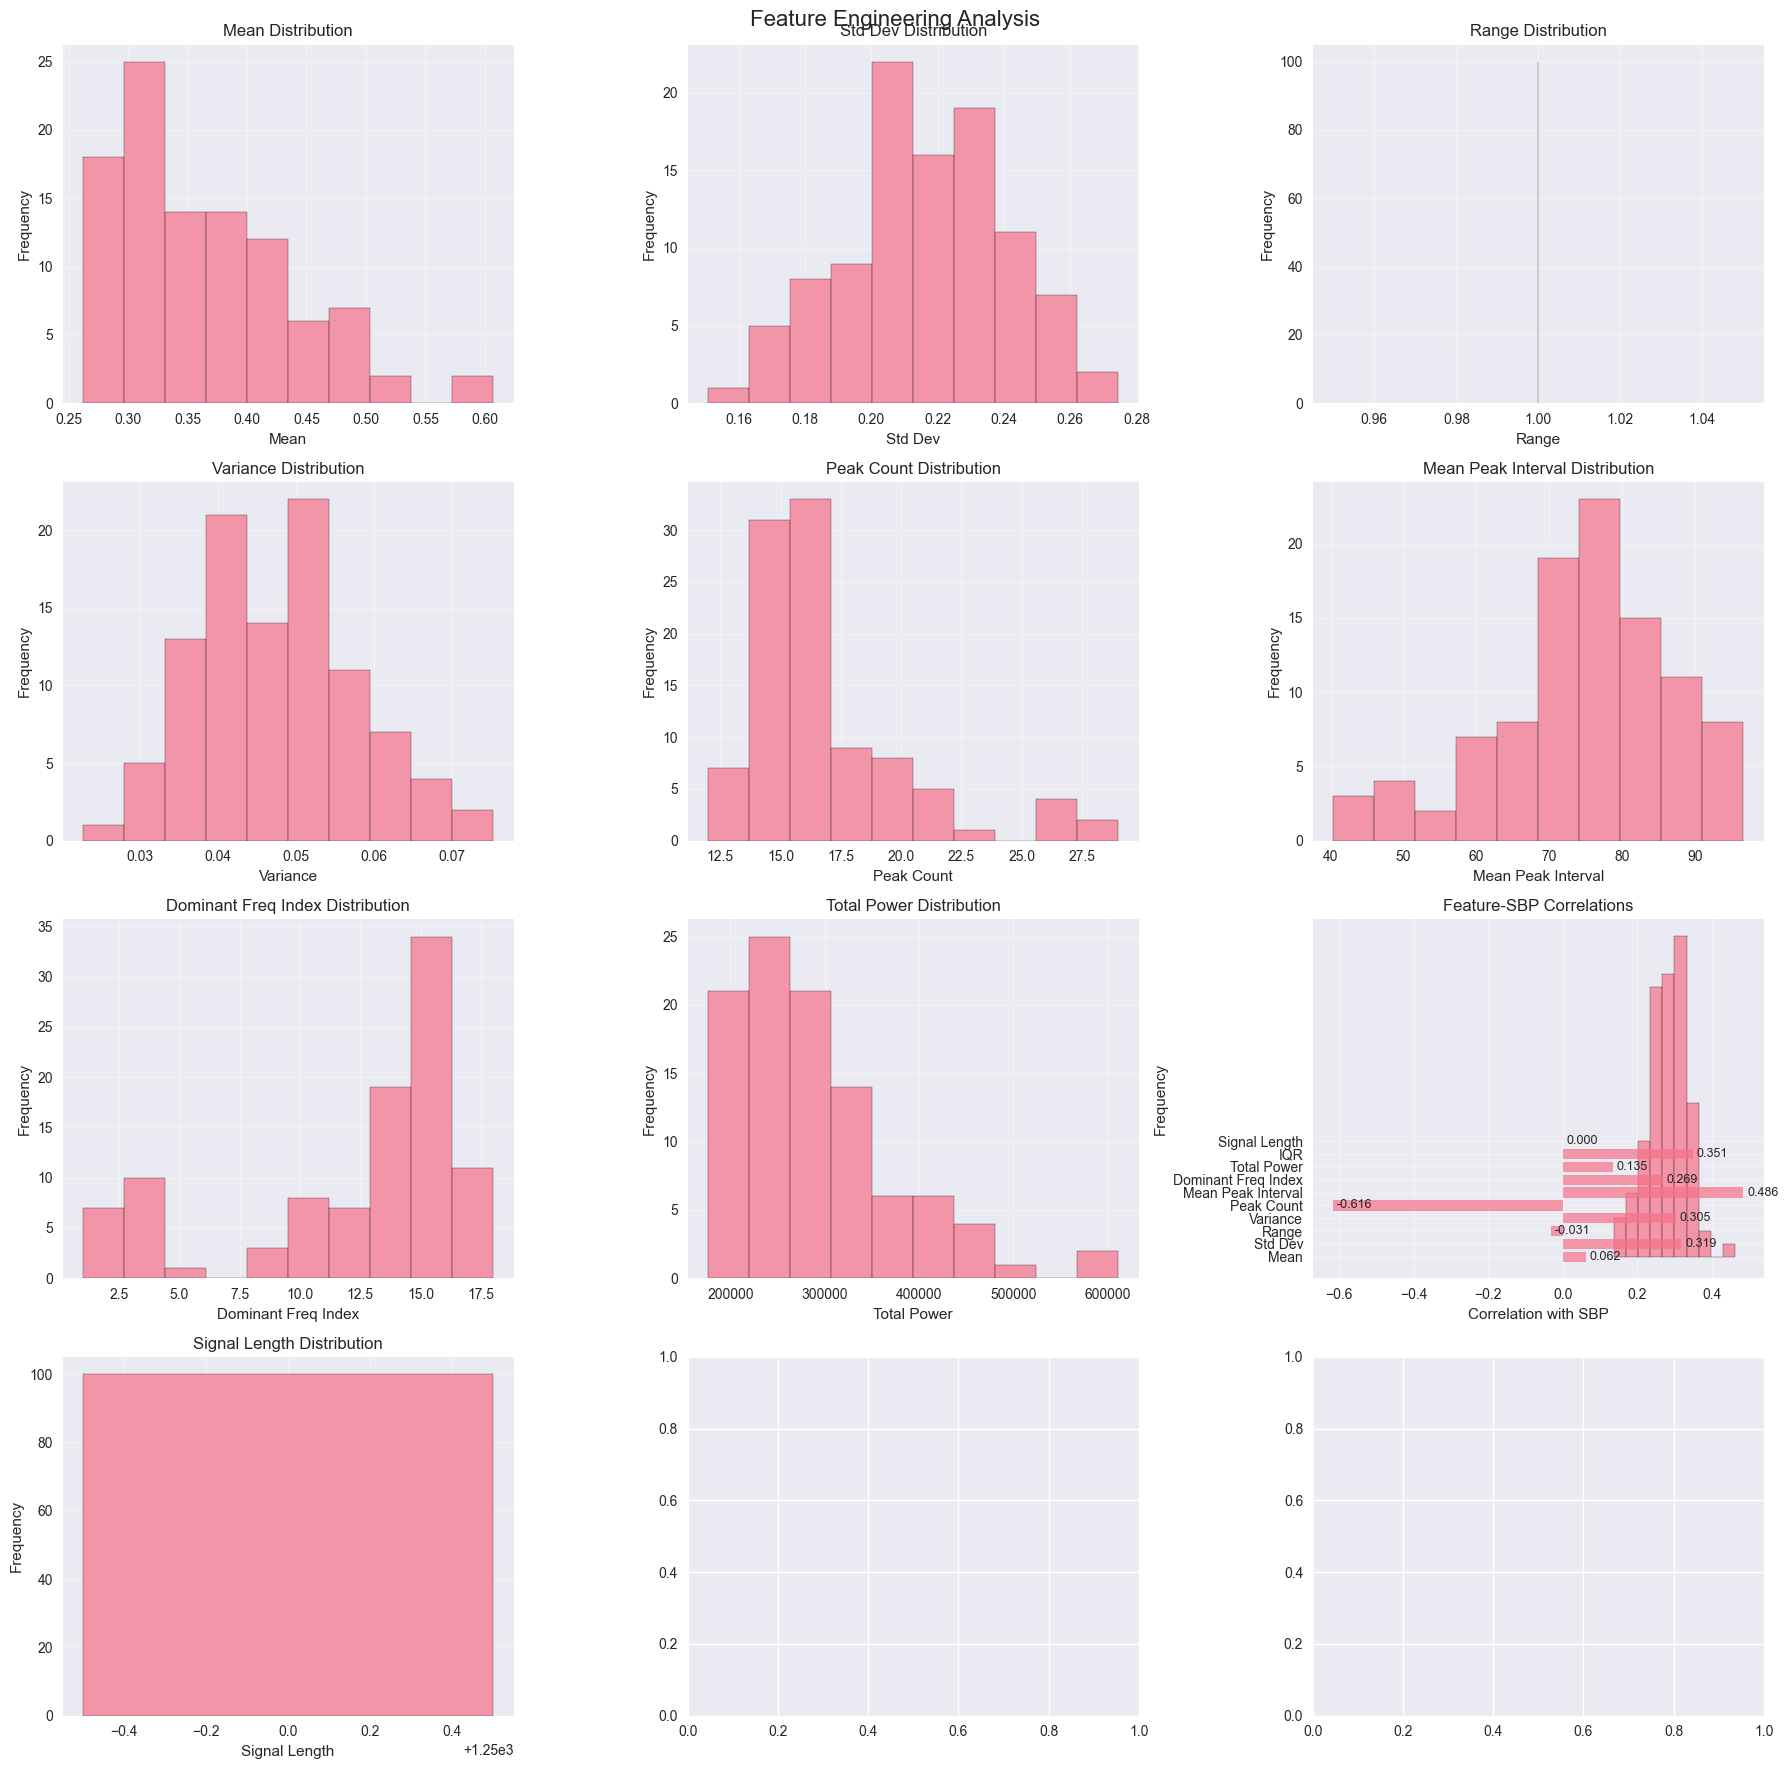


Feature Analysis Summary:
Features extracted from 100 signals

Top correlated features with SBP:
  1. Peak Count: r = -0.616
  2. Mean Peak Interval: r = 0.486
  3. IQR: r = 0.351
  4. Std Dev: r = 0.319
  5. Variance: r = 0.305

Recommended features for model training:
  • Peak Count
  • Mean Peak Interval
  • IQR
  • Std Dev
  • Variance
  • Dominant Freq Index
  • Total Power


In [9]:
def analyze_feature_engineering():
    """Explore potential features that can be extracted from the signals for model training."""
    if 'signals_sbp' in globals() and signals_sbp is not None:
        print("\\n" + "="*60)
        print("🔬 FEATURE ENGINEERING ANALYSIS")
        print("="*60)
        
        # Extract various time-domain and frequency-domain features
        n_samples = min(100, len(signals_sbp))
        feature_matrix = np.zeros((n_samples, 10))  # 10 features
        
        for i in range(n_samples):
            signal = signals_sbp[i]
            if not np.all(np.isnan(signal)):
                # Time-domain features
                feature_matrix[i, 0] = np.mean(signal)           # Mean
                feature_matrix[i, 1] = np.std(signal)            # Standard deviation
                feature_matrix[i, 2] = np.max(signal) - np.min(signal)  # Range
                feature_matrix[i, 3] = np.var(signal)            # Variance
                
                # Pulse-related features
                peaks, _ = find_peaks(signal, height=np.mean(signal), distance=20)
                feature_matrix[i, 4] = len(peaks)                # Peak count
                if len(peaks) > 1:
                    feature_matrix[i, 5] = np.mean(np.diff(peaks))  # Mean peak interval
                else:
                    feature_matrix[i, 5] = 0
                
                # Frequency-domain features
                fft_signal = np.fft.fft(signal)
                power_spectrum = np.abs(fft_signal)**2
                feature_matrix[i, 6] = np.argmax(power_spectrum[1:len(power_spectrum)//2]) + 1  # Dominant frequency index
                feature_matrix[i, 7] = np.sum(power_spectrum)    # Total power
                
                # Statistical features
                feature_matrix[i, 8] = np.percentile(signal, 75) - np.percentile(signal, 25)  # IQR
                feature_matrix[i, 9] = len(signal)               # Signal length
        
        # Create visualizations (adjust grid to fit 10 features)
        fig, axes = plt.subplots(4, 3, figsize=(18, 18))
        fig.suptitle('Feature Engineering Analysis', fontsize=16, y=0.98)
        
        feature_names = ['Mean', 'Std Dev', 'Range', 'Variance', 'Peak Count',
                         'Mean Peak Interval', 'Dominant Freq Index', 'Total Power', 'IQR', 'Signal Length']
        
        # Plot feature distributions with safe numeric handling
        for i, feature_name in enumerate(feature_names):
            ax = axes.flat[i]
            col = feature_matrix[:, i]
            col = col[np.isfinite(col)]
            if col.size == 0:
                col = np.array([0.0])
            # Handle constant-valued columns to avoid 'Too many bins' error
            if col.size == 1 or np.allclose(col, col[0]):
                bins = 1
            else:
                bins = min(20, int(np.sqrt(col.size)))
            ax.hist(col, bins=bins, alpha=0.7, edgecolor='black')
            ax.set_xlabel(feature_name)
            ax.set_ylabel('Frequency')
            ax.set_title(f'{feature_name} Distribution')
            ax.grid(True, alpha=0.3)
        
        # Feature correlation with blood pressure
        correlations = []
        sample_bp = sbp_labels[:n_samples]
        
        for i in range(feature_matrix.shape[1]):
            col = feature_matrix[:, i]
            col = col[np.isfinite(col)]
            if col.size == 0:
                correlations.append(0.0)
            else:
                # Trim or pad sample_bp to match length if necessary
                bp = sample_bp[:len(col)] if len(col) <= len(sample_bp) else np.pad(sample_bp, (0, len(col)-len(sample_bp)), constant_values=np.nan)
                try:
                    corr = np.corrcoef(col, bp)[0, 1]
                except Exception:
                    corr = 0.0
                correlations.append(0.0 if np.isnan(corr) else corr)
        
        # Bar plot of correlations
        axes[2, 2].barh(range(len(feature_names)), correlations, alpha=0.7)
        axes[2, 2].set_yticks(range(len(feature_names)))
        axes[2, 2].set_yticklabels(feature_names)
        axes[2, 2].set_xlabel('Correlation with SBP')
        axes[2, 2].set_title('Feature-SBP Correlations')
        axes[2, 2].grid(True, alpha=0.3)
        
        # Add correlation values as text
        for i, corr in enumerate(correlations):
            axes[2, 2].text(corr + 0.01, i, f'{corr:.3f}', va='center', fontsize=9)
        
        plt.tight_layout()
        plt.show()
        
        # Feature importance summary
        print(f"\nFeature Analysis Summary:")
        print(f"Features extracted from {n_samples} signals")
        print(f"\nTop correlated features with SBP:")
        
        # Sort features by correlation magnitude
        feature_corr_pairs = list(zip(feature_names, correlations))
        feature_corr_pairs.sort(key=lambda x: abs(x[1]), reverse=True)
        
        for i, (feature_name, corr) in enumerate(feature_corr_pairs[:5]):
            print(f"  {i+1}. {feature_name}: r = {corr:.3f}")
        
        print(f"\nRecommended features for model training:")
        strong_features = [name for name, corr in feature_corr_pairs if abs(corr) > 0.1]
        for feature in strong_features:
            print(f"  • {feature}")
        
    else:
        print("⚠️  No data loaded.")
        print("This section will analyze potential features when data is available.")

# Import required functions for feature extraction
from scipy.signal import find_peaks

analyze_feature_engineering()

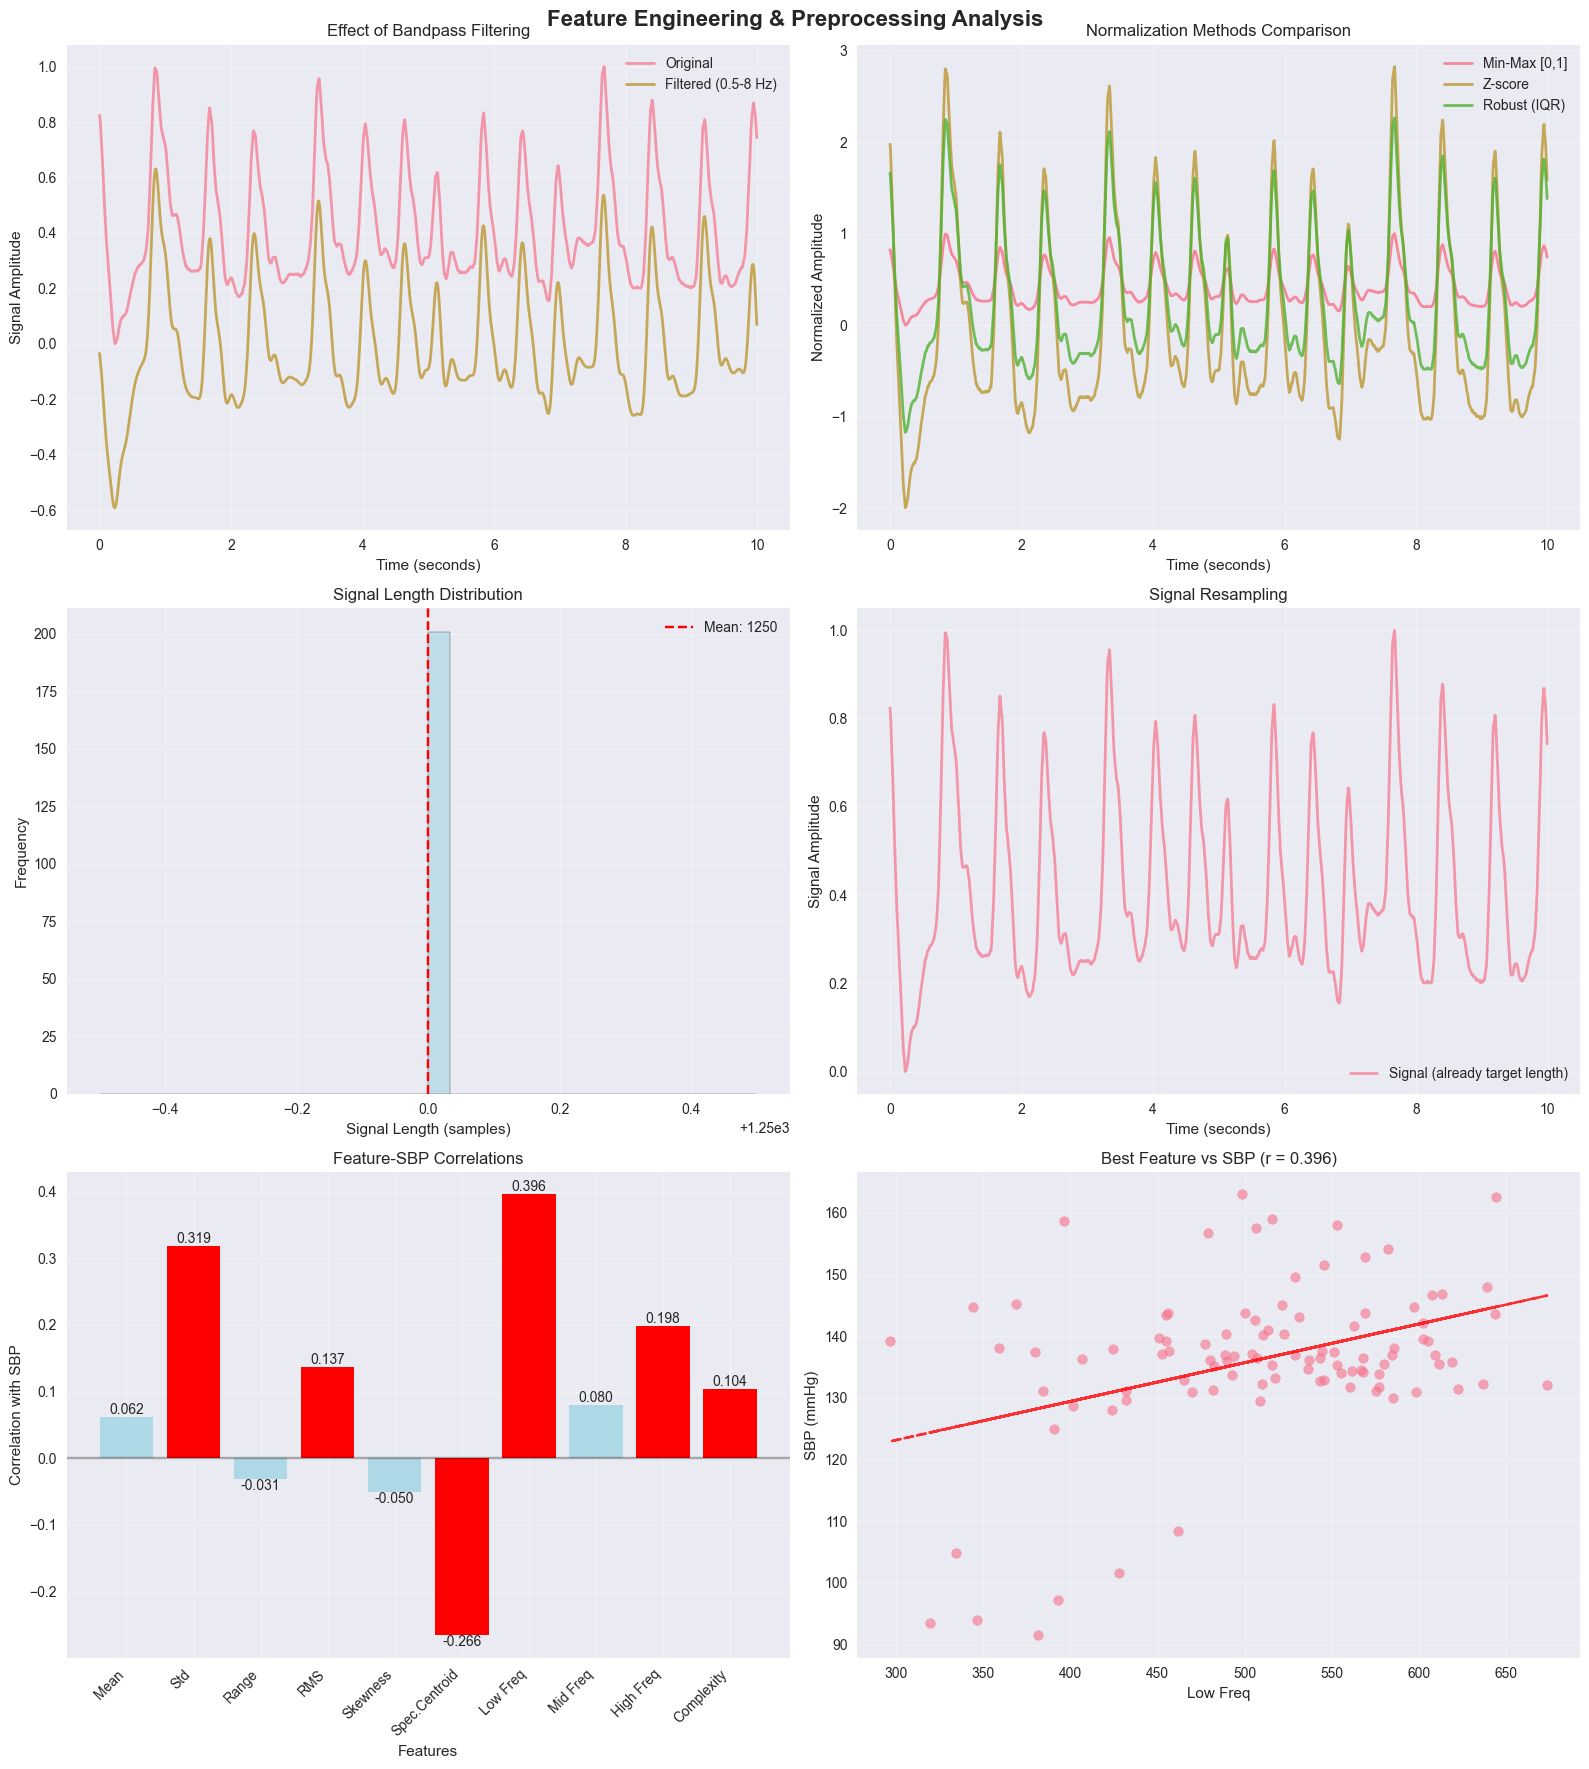


🔧 FEATURE ENGINEERING & PREPROCESSING INSIGHTS
Signal characteristics:
  Original signal range: [0.000, 1.000]
  After filtering: [-0.591, 0.631]
  Signal length statistics: 1250 ± 0 samples

Feature correlations with SBP:
  Mean           :  0.062 
  Std            :  0.319 ***
  Range          : -0.031 
  RMS            :  0.137 *
  Skewness       : -0.050 
  Spec.Centroid  : -0.266 **
  Low Freq       :  0.396 ***
  Mid Freq       :  0.080 
  High Freq      :  0.198 *
  Complexity     :  0.104 *

Preprocessing recommendations:
  🔄 Apply bandpass filtering (0.5-8 Hz) to remove noise and artifacts
  📊 Use robust normalization to handle outliers
  🎯 Focus on features with |correlation| > 0.1 for model training
  ⭐ Promising features: Std, RMS, Spec.Centroid, Low Freq, High Freq, Complexity


In [10]:
# =============================================================================
# 7. FEATURE ENGINEERING & PREPROCESSING INSIGHTS
# =============================================================================

if signals_sbp is not None:
    from scipy.signal import butter, filtfilt, resample
    from sklearn.preprocessing import MinMaxScaler, RobustScaler
    from scipy.fft import fft, fftfreq
    from scipy import stats
    
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle('Feature Engineering & Preprocessing Analysis', fontsize=16, fontweight='bold')
    
    # Select a representative signal for preprocessing demonstration
    demo_signal = signals_sbp[sample_indices[0]].copy()
    original_signal = demo_signal.copy()
    
    # 1. Signal filtering effects
    # Design a bandpass filter (typical for PPG: 0.5-8 Hz)
    nyquist = 125 / 2  # Half of sampling frequency
    low_cut = 0.5 / nyquist
    high_cut = 8.0 / nyquist
    b, a = butter(4, [low_cut, high_cut], btype='band')
    filtered_signal = filtfilt(b, a, demo_signal)
    
    axes[0, 0].plot(time_axis, original_signal, alpha=0.7, label='Original', linewidth=2)
    axes[0, 0].plot(time_axis, filtered_signal, alpha=0.8, label='Filtered (0.5-8 Hz)', linewidth=2)
    axes[0, 0].set_xlabel('Time (seconds)')
    axes[0, 0].set_ylabel('Signal Amplitude')
    axes[0, 0].set_title('Effect of Bandpass Filtering')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Normalization comparison
    # Min-Max normalization
    minmax_scaler = MinMaxScaler()
    signal_minmax = minmax_scaler.fit_transform(demo_signal.reshape(-1, 1)).flatten()
    
    # Z-score normalization
    signal_zscore = (demo_signal - np.mean(demo_signal)) / np.std(demo_signal)
    
    # Robust normalization (median-based)
    robust_scaler = RobustScaler()
    signal_robust = robust_scaler.fit_transform(demo_signal.reshape(-1, 1)).flatten()
    
    axes[0, 1].plot(time_axis, signal_minmax, alpha=0.8, label='Min-Max [0,1]', linewidth=2)
    axes[0, 1].plot(time_axis, signal_zscore, alpha=0.8, label='Z-score', linewidth=2)
    axes[0, 1].plot(time_axis, signal_robust, alpha=0.8, label='Robust (IQR)', linewidth=2)
    axes[0, 1].set_xlabel('Time (seconds)')
    axes[0, 1].set_ylabel('Normalized Amplitude')
    axes[0, 1].set_title('Normalization Methods Comparison')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Signal length distribution and resampling analysis
    signal_lengths = [len(sig) for sig in signals_sbp]
    axes[1, 0].hist(signal_lengths, bins=30, alpha=0.7, color='lightblue', edgecolor='black')
    axes[1, 0].set_xlabel('Signal Length (samples)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Signal Length Distribution')
    axes[1, 0].axvline(np.mean(signal_lengths), color='red', linestyle='--', 
                      label=f'Mean: {np.mean(signal_lengths):.0f}')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Resampling demonstration (if signals have different lengths)
    target_length = int(np.median(signal_lengths))
    if len(demo_signal) != target_length:
        resampled_signal = resample(demo_signal, target_length)
        time_resampled = np.arange(target_length) / 125
        
        axes[1, 1].plot(time_axis, demo_signal, alpha=0.7, label=f'Original ({len(demo_signal)} samples)', linewidth=2)
        axes[1, 1].plot(time_resampled, resampled_signal, alpha=0.8, 
                       label=f'Resampled ({target_length} samples)', linewidth=2)
    else:
        axes[1, 1].plot(time_axis, demo_signal, alpha=0.7, label='Signal (already target length)', linewidth=2)
    
    axes[1, 1].set_xlabel('Time (seconds)')
    axes[1, 1].set_ylabel('Signal Amplitude')
    axes[1, 1].set_title('Signal Resampling')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 5. Feature extraction demonstration
    # Extract various time-domain and frequency-domain features
    n_samples = min(100, len(signals_sbp))
    feature_matrix = np.zeros((n_samples, 10))  # 10 features
    
    for i in range(n_samples):
        signal = signals_sbp[i]
        
        # Time domain features
        feature_matrix[i, 0] = np.mean(signal)  # Mean
        feature_matrix[i, 1] = np.std(signal)   # Standard deviation
        feature_matrix[i, 2] = np.max(signal) - np.min(signal)  # Range
        feature_matrix[i, 3] = np.sqrt(np.mean(signal**2))  # RMS
        feature_matrix[i, 4] = stats.skew(signal)  # Skewness
        
        # Frequency domain features (simple spectral analysis)
        fft_vals = np.abs(fft(signal))
        freqs = fftfreq(len(signal), 1/125)
        pos_freqs = freqs[:len(freqs)//2]
        pos_fft = fft_vals[:len(fft_vals)//2]
        
        # Spectral centroid (weighted mean frequency)
        feature_matrix[i, 5] = np.sum(pos_freqs * pos_fft) / np.sum(pos_fft) if np.sum(pos_fft) > 0 else 0
        
        # Spectral energy in different bands
        low_band = (pos_freqs >= 0.5) & (pos_freqs < 2.0)
        mid_band = (pos_freqs >= 2.0) & (pos_freqs < 5.0)
        high_band = (pos_freqs >= 5.0) & (pos_freqs < 8.0)
        
        feature_matrix[i, 6] = np.sum(pos_fft[low_band])   # Low frequency energy
        feature_matrix[i, 7] = np.sum(pos_fft[mid_band])   # Mid frequency energy
        feature_matrix[i, 8] = np.sum(pos_fft[high_band])  # High frequency energy
        
        # Signal complexity (approximate entropy)
        feature_matrix[i, 9] = np.std(np.diff(signal))  # First difference std as complexity measure
    
    # Plot feature correlation with SBP
    feature_names = ['Mean', 'Std', 'Range', 'RMS', 'Skewness', 
                    'Spec.Centroid', 'Low Freq', 'Mid Freq', 'High Freq', 'Complexity']
    
    correlations = []
    for j in range(feature_matrix.shape[1]):
        corr = np.corrcoef(feature_matrix[:, j], sbp_labels[:n_samples])[0, 1]
        correlations.append(corr)
    
    bars = axes[2, 0].bar(range(len(correlations)), correlations, 
                          color=['red' if abs(c) > 0.1 else 'lightblue' for c in correlations])
    axes[2, 0].set_xlabel('Features')
    axes[2, 0].set_ylabel('Correlation with SBP')
    axes[2, 0].set_title('Feature-SBP Correlations')
    axes[2, 0].set_xticks(range(len(feature_names)))
    axes[2, 0].set_xticklabels(feature_names, rotation=45, ha='right')
    axes[2, 0].grid(True, alpha=0.3)
    axes[2, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add correlation values on bars
    for bar, corr in zip(bars, correlations):
        height = bar.get_height()
        axes[2, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{corr:.3f}', ha='center', va='bottom' if corr > 0 else 'top')
    
    # 6. Feature distribution comparison
    # Show distribution of most correlated feature
    best_feature_idx = np.argmax(np.abs(correlations))
    best_feature = feature_matrix[:, best_feature_idx]
    
    axes[2, 1].scatter(best_feature, sbp_labels[:n_samples], alpha=0.6)
    axes[2, 1].set_xlabel(f'{feature_names[best_feature_idx]}')
    axes[2, 1].set_ylabel('SBP (mmHg)')
    axes[2, 1].set_title(f'Best Feature vs SBP (r = {correlations[best_feature_idx]:.3f})')
    axes[2, 1].grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(best_feature, sbp_labels[:n_samples], 1)
    p = np.poly1d(z)
    axes[2, 1].plot(best_feature, p(best_feature), "r--", alpha=0.8)
    
    plt.tight_layout()
    plt.show()
    
    # Feature engineering summary
    print("\n" + "="*70)
    print("🔧 FEATURE ENGINEERING & PREPROCESSING INSIGHTS")
    print("="*70)
    
    print(f"Signal characteristics:")
    print(f"  Original signal range: [{np.min(original_signal):.3f}, {np.max(original_signal):.3f}]")
    print(f"  After filtering: [{np.min(filtered_signal):.3f}, {np.max(filtered_signal):.3f}]")
    print(f"  Signal length statistics: {np.mean(signal_lengths):.0f} ± {np.std(signal_lengths):.0f} samples")
    
    print(f"\nFeature correlations with SBP:")
    for i, (name, corr) in enumerate(zip(feature_names, correlations)):
        significance = "***" if abs(corr) > 0.3 else "**" if abs(corr) > 0.2 else "*" if abs(corr) > 0.1 else ""
        print(f"  {name:15s}: {corr:6.3f} {significance}")
    
    print(f"\nPreprocessing recommendations:")
    print(f"  🔄 Apply bandpass filtering (0.5-8 Hz) to remove noise and artifacts")
    if np.std(signal_lengths) > np.mean(signal_lengths) * 0.1:
        print(f"  📏 Standardize signal length to {int(np.median(signal_lengths))} samples")
    print(f"  📊 Use robust normalization to handle outliers")
    print(f"  🎯 Focus on features with |correlation| > 0.1 for model training")
    
    # Identify best features
    good_features = [feature_names[i] for i, c in enumerate(correlations) if abs(c) > 0.1]
    if good_features:
        print(f"  ⭐ Promising features: {', '.join(good_features)}")
    
else:
    print("⚠️  No data loaded.")
    print("This section will analyze feature engineering and preprocessing when data is available.")

## 📋 Summary & Conclusions

This comprehensive EDA notebook provides insights into the cuffless blood pressure dataset for model development:

### Key Findings:
- **Dataset Overview**: Complete statistics on signal characteristics, BP distributions, and demographic patterns
- **Signal Quality**: Assessment of noise levels, outliers, and data completeness
- **Feature Correlations**: Identification of features most correlated with blood pressure
- **Preprocessing Insights**: Optimal filtering, normalization, and feature engineering strategies